## IBM Quantum Challenge Fall 2021

# Challenge 3: Classify images with quantum machine learning

<div class="alert alert-block alert-info">
    
We recommend that you switch to **light** workspace theme under the Account menu in the upper right corner for optimal experience.

## Introduction

Machine learning is a technology that has attracted a great deal of attention due to its high performance and versatility. In fact, it has been put to practical use in many industries with the recent development of algorithms and the increase of computational resources. A typical example is computer vision, where machine learning is now able to classify images with the same or better accuracy than humans. For example, the ability to automatically classify clothing images has made online shopping for clothes more convenient.

The application of quantum computation to machine learning has recently been shown to have the potential for even greater capabilities. Various algorithms have been proposed for quantum machine learning, such as the quantum support vector machine (QSVM) and quantum generative adversarial networks (QGANs). In this challenge, you will use QSVM to tackle the clothing image classification task.

QSVM is a quantum version of the support vector machine (SVM), a classical machine learning algorithm. There are various approaches to QSVM, some aim to accelerate computation assuming fault-tolerant quantum computers, while others aim to achieve higher expressive power assuming noisy, near-term devices. In this challenge, we will focus on the latter, and the details will be explained later.

For this implementation of QSVM, you will be able to make choices on how you want to compose your quantum model, in particular focusing on the quantum feature map. This is motivated by the tradeoff that a more complex feature map would have greater representation power but be more susceptible to noise, which could be especially critical when using noisy, near-term devices.

Many of the concepts that appear in this challenge are explained in the 2021 Qiskit Global Summer School (QGSS). The materials and lecture videos are available, and it is recommended that you study them as well. Refer to the links in each part for the corresponding lectures.

<center><img src="./resources/ecommerce.jpg" width="640" /></center>

## Challenge
<div class="alert alert-block alert-success">

**Goal**

Implement a QSVM model for multiclass classification and predict labels accurately. 
    
**Plan**

First, you will learn how to construct QSVM for binary classification of a simple dataset. Then apply what you have learned to a more complex problem, 3-class classification of a different dataset.

**1. Tutorial - QSVM for binary classification of MNIST:** familiarize yourself with a typical workflow for QSVM and find the best combination of dimentions/feature maps.

**2. Challenge - QSVM for 3-class classification of Fashion-MNIST:** implement a 3-class classifier using binary QSVM classifers. Perform similar investigation as in the first part to find the best combination of dimentions/feature maps. Achieve better accuracy with smaller feature map circuits.

</div>

<div class="alert alert-block alert-info">

Before you begin, we recommend watching the [**Qiskit Machine Learning Demo Session with Anton Dekusar**](https://youtu.be/claoY57eVIc?t=1814) and check out the corresponding [**demo notebook**](https://github.com/qiskit-community/qiskit-application-modules-demo-sessions/tree/main/qiskit-machine-learning) to learn how to do classifications using QSVM.

</div>

In [1]:
# General imports
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings

warnings.filterwarnings("ignore")

# scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskit imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

## Part 1: Tutorial - QSVM for binary classification of MNIST

In this part, you will apply QSVM to the binary classification of handwritten numbers 4 and 9. Through this tutorial, you will learn the workflow of applying QSVM to binary classification. Find better combinations and achieve higher accuracy.

Related QGSS material:
- [**Lab 3**](https://www.youtube.com/watch?v=GVhCOTzAkCM&list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&index=17)

### 1. Data preparation

The data we are going to work with at the beginning is a small subset of the well known handwritten digits dataset, which is available publicly. We will be aiming to differentiate between '4' and '9'. 

There are a total of 100 data in the dataset. Of these, eighty are labeled training data, and the remaining twenty are unlabeled test data. Each data is a 28x28 image of a digit, collapsed into an array, where each element is an integer between 0 (white) and 255 (black). To use the dataset for quantum classification, we need to scale the range to between -1 and 1, and reduce the dimensionality to the number of qubits we want to use (here N_DIM=5).

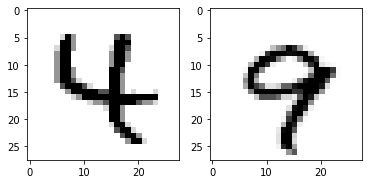

In [2]:
# Load MNIST dataset
DATA_PATH = './resources/ch3_part1.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Visualize samples
fig = plt.figure()

LABELS = [4, 9]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

In [3]:
# Standardize
ss = StandardScaler()
sample_train = ss.fit_transform(sample_train)
sample_val = ss.transform(sample_val)
sample_test = ss.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
mms = MinMaxScaler((-1, 1))
sample_train = mms.fit_transform(sample_train)
sample_val = mms.transform(sample_val)
sample_test = mms.transform(sample_test)

### 2. Data Encoding

We will take the classical data and encode it to the quantum state space using a quantum feature map. The choice of which feature map to use is important and may depend on the given dataset we want to classify. Here we'll look at the feature maps available in Qiskit, before selecting and customising one to encode our data.

### 2.1 Quantum Feature Maps
As the name suggests, a quantum feature map $\phi(\mathbf{x})$ is a map from the classical feature vector $\mathbf{x}$ to the quantum state $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$. This is facilitated by applying the unitary operation $\mathcal{U}_{\Phi(\mathbf{x})}$ on the initial state $|0\rangle^{n}$ where _n_ is the number of qubits being used for encoding.

The following feature maps currently available in Qiskit are those introduced in [**_Havlicek et al_.  Nature **567**, 209-212 (2019)**](https://www.nature.com/articles/s41586-019-0980-2), in particular the `ZZFeatureMap` is conjectured to be hard to simulate classically and can be implemented as short-depth circuits on near-term quantum devices.

- [**`PauliFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html)
- [**`ZZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html)
- [**`ZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)

The `PauliFeatureMap` is defined as:

```python
PauliFeatureMap(feature_dimension=None, reps=2, 
                entanglement='full', paulis=None, 
                data_map_func=None, parameter_prefix='x',
                insert_barriers=False)
```

and describes the unitary operator of depth $d$:

$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right), $$

which contains layers of Hadamard gates interleaved with entangling blocks, $U_{\Phi(\mathbf{x})}$, encoding the classical data as shown in circuit diagram below for $d=2$.

<center><img src="./resources/featuremap.png" width="1000" /></center>

Within the entangling blocks, $U_{\Phi(\mathbf{x})}$: $P_i \in \{ I, X, Y, Z \}$ denotes the Pauli matrices, the index $S$ describes connectivities between different qubits or datapoints: $S \in \{\binom{n}{k}\ combinations,\ k = 1,... n \}$, and by default the data mapping function $\phi_S(\mathbf{x})$ is 
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

when $k = 1, P_0 = Z$, this is the `ZFeatureMap`: 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$

which is defined as:
```python
ZFeatureMap(feature_dimension, reps=2, 
            data_map_func=None, insert_barriers=False)
```

/opt/conda/lib/python3.8/site-packages/sympy/core/expr.py:2451: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


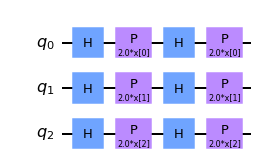

In [4]:
# 3 features, depth 2
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.decompose().draw('mpl')

Note the lack of entanglement in this feature map, this means that this feature map is simple to simulate classically and will not provide quantum advantage.

and when $k = 2, P_0 = Z, P_1 = ZZ$, this is the `ZZFeatureMap`: 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ 

which is defined as:
```python
ZZFeatureMap(feature_dimension, reps=2, 
             entanglement='full', data_map_func=None, 
             insert_barriers=False)
```

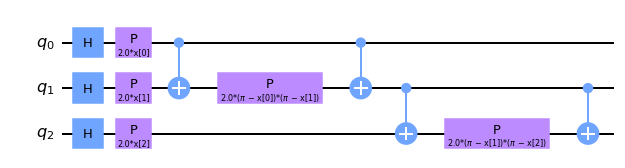

In [5]:
# 3 features, depth 1, linear entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

Note that there is entanglement in the feature map, we can define the entanglement map:

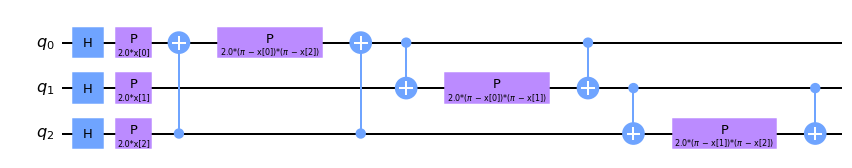

In [6]:
# 3 features, depth 1, circular entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='circular')
map_zz.decompose().draw('mpl')

We can customise the Pauli gates in the feature map, for example, $P_0 = X, P_1 = Y, P_2 = ZZ$:
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_{j} \phi_{\{j\}}(\mathbf{x}) \, Y_j\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, X_j\right) \, H^{\otimes n} \right)^d.$$ 

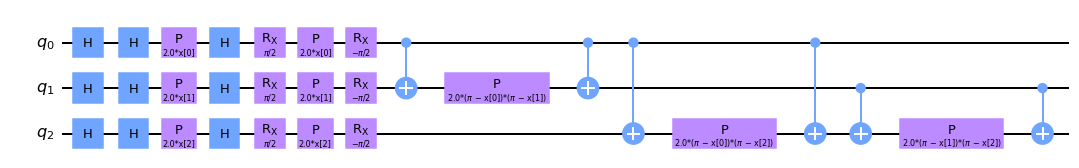

In [7]:
# 3 features, depth 1
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

The [`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) and [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) functions in Qiskit's circuit library can also be used to create parameterised quantum circuits as feature maps. 

```python
TwoLocal(num_qubits=None, reps=3, rotation_blocks=None, 
         entanglement_blocks=None, entanglement='full',  
         skip_unentangled_qubits=False, 
         skip_final_rotation_layer=False, 
         parameter_prefix='θ', insert_barriers=False, 
         initial_state=None)
```

```python
NLocal(num_qubits=None, reps=1, rotation_blocks=None, 
       entanglement_blocks=None, entanglement=None,   
       skip_unentangled_qubits=False, 
       skip_final_rotation_layer=False, 
       overwrite_block_parameters=True, 
       parameter_prefix='θ', insert_barriers=False, 
       initial_state=None, name='nlocal')
```

Both functions create parameterised circuits of alternating rotation and entanglement layers. In both layers, parameterised circuit-blocks act on the circuit in a defined way. In the rotation layer, the blocks are applied stacked on top of each other, while in the entanglement layer according to the entanglement strategy. Each layer is repeated a number of times, and by default a final rotation layer is appended.

In `NLocal`, the circuit blocks can have arbitrary sizes (smaller equal to the number of qubits in the circuit), while in `TwoLocal`, the rotation layers are single qubit gates applied on all qubits and the entanglement layer uses two-qubit gates.

For example, here is a `TwoLocal` circuit, with $R_y$ and $R_Z$ gates in the rotation layer and $CX$ gates in the entangling layer with circular entanglement:

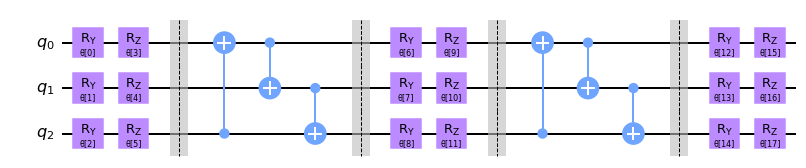

In [8]:
twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
twolocal.decompose().draw('mpl')

and the equivalent `NLocal` circuit:

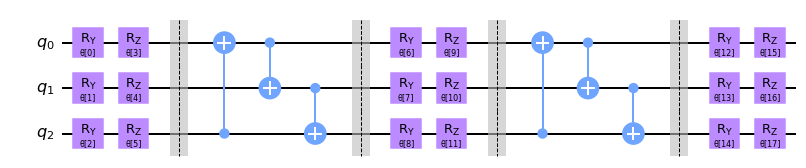

In [9]:
twolocaln = NLocal(num_qubits=3, reps=2,
               rotation_blocks=[RYGate(Parameter('a')), RZGate(Parameter('a'))], 
               entanglement_blocks=CXGate(), 
               entanglement='circular', insert_barriers=True)
twolocaln.decompose().draw('mpl')

Let's encode the first training sample using the `PauliFeatureMap`:

In [10]:
print(f'First training data: {sample_train[0]}')

First training data: [-0.47556192 -0.42255721  0.30047069  0.00530938 -0.89405976]


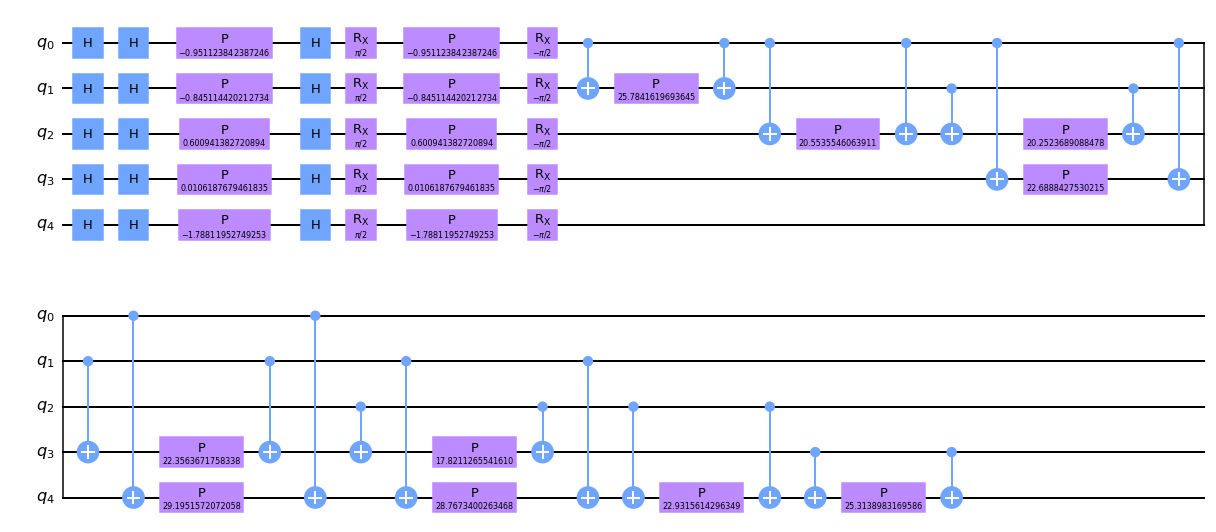

In [11]:
encode_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
encode_circuit = encode_map.bind_parameters(sample_train[0])
encode_circuit.decompose().draw(output='mpl')

<div class="alert alert-block alert-success">

**Challenge 3a**

Construct a feature map to encode a 5-dimensionally embedded data, using 'ZZFeatureMap' with 3 repetitions, 'circular' entanglement and the rest as default.
    
</div>

Submission format:
```python
ex3a_fmap = ZZFeatureMap(...)
```

In [ ]:
##############################
# Provide your code here


ex3a_fmap = 


##############################

In [ ]:
# Check your answer and submit using the following code
from qc_grader import grade_ex3a
grade_ex3a(ex3a_fmap)

### 2.2 Quantum Kernel Estimation

A quantum feature map, $\phi(\mathbf{x})$, naturally gives rise to a quantum kernel, $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$, which can be seen as a measure of similarity: $k(\mathbf{x}_i,\mathbf{x}_j)$ is large when $\mathbf{x}_i$ and $\mathbf{x}_j$ are close. 

When considering finite data, we can represent the quantum kernel as a matrix: 
$K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$. We can calculate each element of this kernel matrix on a quantum computer by calculating the transition amplitude:
$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} = 
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$
assuming the feature map is a parameterized quantum circuit, which can be described as a unitary transformation $\mathbf{U_\phi}(\mathbf{x})$ on $n$ qubits. 

This provides us with an estimate of the quantum kernel matrix, which we can then use in a kernel machine learning algorithm, such as support vector classification.

As discussed in [***Havlicek et al*.  Nature 567, 209-212 (2019)**](https://www.nature.com/articles/s41586-019-0980-2), quantum kernel machine algorithms only have the potential of quantum advantage over classical approaches if the corresponding quantum kernel is hard to estimate classically. 

As we will see later, the hardness of estimating the kernel with classical resources is of course only a necessary and not always sufficient condition to obtain a quantum advantage. 

However, it was proven recently in [***Liu et al.* arXiv:2010.02174 (2020)**](https://arxiv.org/abs/2010.02174) that learning problems exist for which learners with access to quantum kernel methods have a quantum advantage over all classical learners.

With our training and testing datasets ready, we set up the `QuantumKernel` class with the PauliFeatureMap, and use the `BasicAer` `statevector_simulator` to estimate the training and testing kernel matrices.

In [ ]:
pauli_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=Aer.get_backend('statevector_simulator'))

Let's calculate the transition amplitude between the first and second training data samples, one of the entries in the training kernel matrix.

In [ ]:
print(f'First training data : {sample_train[0]}')
print(f'Second training data: {sample_train[1]}')

First we create and draw the circuit:

In [ ]:
pauli_circuit = pauli_kernel.construct_circuit(sample_train[0], sample_train[1])
pauli_circuit.decompose().decompose().draw(output='mpl')

The parameters in the gates are a little difficult to read, but notice how the circuit is symmetrical, with one half encoding one of the data samples, the other half encoding the other. 

We then simulate the circuit. We will use the `qasm_simulator` since the circuit contains measurements, but increase the number of shots to reduce the effect of sampling noise. 

In [ ]:
backend = Aer.get_backend('qasm_simulator')
job = execute(pauli_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(pauli_circuit)

The transition amplitude is the proportion of counts in the zero state:

In [ ]:
print(f"Transition amplitude: {counts['0'*N_DIM]/sum(counts.values())}")

This process is then repeated for each pair of training data samples to fill in the training kernel matrix, and between each training and testing data sample to fill in the testing kernel matrix. Note that each matrix is symmetric, so to reduce computation time, only half the entries are calculated explicitly. 

Here we compute and plot the training and testing kernel matrices:

In [ ]:
matrix_train = pauli_kernel.evaluate(x_vec=sample_train)
matrix_val = pauli_kernel.evaluate(x_vec=sample_val, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_val),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("validation kernel matrix")
plt.show()

</div>
    
<div class="alert alert-block alert-success">

**Challenge 3b**

Calculate the transition amplitude between $x = (-0.5, -0.4, 0.3, 0, -0.9)$ and $y = (0, -0.7, -0.3, 0, -0.4)$ using the 'ZZFeatureMap' with 3 repetitions, 'circular' entanglement and the rest as default. Use the `qasm_simulator` with `shots=8192`, `seed_simulator=1024` and `seed_transpiler=1024`.
    
</div>

In [ ]:
x = [-0.5, -0.4, 0.3, 0, -0.9]
y = [0, -0.7, -0.3, 0, -0.4]

##############################
# Provide your code here


ex3b_amp = 


##############################

In [ ]:
# Check your answer and submit using the following code
from qc_grader import grade_ex3b
grade_ex3b(ex3b_amp)

Related QGSS materials:
- [**Kernel Trick (Lecture 6.1)**](https://www.youtube.com/watch?v=m6EzmYsEOiI&list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&index=14)
- [**Kernel Trick (Lecture 6.2)**](https://www.youtube.com/watch?v=zw3JYUrS-v8&list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&index=15)

### 2.3 Quantum Support Vector Machine (QSVM)

Introduced in [***Havlicek et al*.  Nature 567, 209-212 (2019)**](https://www.nature.com/articles/s41586-019-0980-2), the quantum kernel support vector classification algorithm consists of these steps:


<center><img src="./resources/qsvc.png" width="1000"></center> 

1. Build the train and test quantum kernel matrices.
    1. For each pair of datapoints in the training dataset $\mathbf{x}_{i},\mathbf{x}_j$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
    2. For each training datapoint $\mathbf{x_i}$ and testing point $\mathbf{y_j}$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
2. Use the train and test quantum kernel matrices in a classical support vector machine classification algorithm.

The `scikit-learn` `svc` algorithm allows us to [**define a custom kernel**](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the `QuantumKernel` class in Qiskit.

The following code takes the training and testing kernel matrices we calculated earlier and  provides them to the `scikit-learn` `svc` algorithm:

In [ ]:
pauli_svc = SVC(kernel='precomputed')
pauli_svc.fit(matrix_train, labels_train)
pauli_score = pauli_svc.score(matrix_val, labels_val)

print(f'Precomputed kernel classification test score: {pauli_score*100}%')

Related QGSS materials:
- [**Classical SVM (Lecture 4.2)**](https://www.youtube.com/watch?v=lpPij21jnZ4&list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&index=9)
- [**Quantum Classifier (Lecture 5.1)**](https://www.youtube.com/watch?v=-sxlXNz7ZxU&list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&index=11)

## Part 2: Challenge - QSVM for 3-class classification of Fashion-MNIST

In this part, you will use what your have learned so far to implement 3-class classification of clothing images and work on improving its accuracy. 
    
<div class="alert alert-block alert-success">

**Challenge 3c**

**Goal**: Implement a 3-class classifier using QSVM and achieve 70% accuracy on clothing image dataset with smaller feature map circuits.

**Dataset**: Fashion-MNIST clothing image dataset. There are following three dataset in this challnge.  
- Train: Both images and labels are given.
- Public test: Images are given and labels are hidden.
- Private test: Both images and labels are hidden.
    
Grading will be performed on both public test and private test data. The purpose of this is to make sure that quantum methods are used, so that cheating is not possible.
    
</div>

### How to implement a multi-class classifier using binary classifiers

So far, you have learned how to implement binary classification with QSVM. Now, how can you scale it up to multi-class classification? There are two approaches to do so. One is the One-vs-Rest approach, and the other is the One-vs-One approach.

1. One-vs-Rest: In this approach, multi-class classification is achieved by combining classifiers for each class that classifies the class as positive and the others as negative. Since one classifier is required for each class, the total number of classifiers required for N-class classification is N. The advantage is that fewer classifiers are needed, and the disadvantage is that the labels are likely to be imbalanced in each classification.
2. One-vs-One: In this approach, multi-class classification is achieved by combining classifiers for each pair of two classes, where one is positive and the other is negative. Since one classifier is required for each label pair, the total number of classifiers required for N-class classification is N(N-1)/2. The advantage is that labels are less likely to be imbalanced in each classification, and the disadvantage is that the number of classifiers required is larger.

Both approaches can be used to solve this problem, but here you will be given hints based on the One-vs-Rest approach. Please follow the hints to solve it.

<center><img src="./resources/onevsrest.png" width="800"></center>

Figure via [cc.gatech.edu](https://www.cc.gatech.edu/classes/AY2016/cs4476_fall/results/proj4/html/jnanda3/index.html)

### 1. Data preparation
The data we are working with here is a small subset of clothing image dataset called Fashion-MNIST, which is a variant of the MNIST dataset. We aim to classify the following labels.
- label 0: T-shirt/top
- label 2: pullover
- label 3: dress

First, let's load the dataset and display one image for each class.

In [ ]:
# Load MNIST dataset
DATA_PATH = './resources/ch3_part2.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Visualize samples
fig = plt.figure()

LABELS = [0, 2, 3]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

Then, preprocess the dataset in the same way as before.
- Standardization
- PCA
- Normalization

Note that you can change the number of features here by changing N_DIM.

In [ ]:
# Standardize
standard_scaler = StandardScaler()
sample_train = standard_scaler.fit_transform(sample_train)
sample_val = standard_scaler.transform(sample_val)
sample_test = standard_scaler.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
min_max_scaler = MinMaxScaler((-1, 1))
sample_train = min_max_scaler.fit_transform(sample_train)
sample_val = min_max_scaler.transform(sample_val)
sample_test = min_max_scaler.transform(sample_test)

### 2. Modeling
Based on the One-vs-Rest approach, you need to create the following three QSVM binary classifiers
- the label 0 and the rest
- the label 2 and the rest
- the label 3 and the rest

Here is the first one as a hint.

### 2.1: Label 0 vs Rest
Create new labels with label 0 as positive(1) and the rest as negative(0) as follows.

In [ ]:
labels_train_0 = np.where(labels_train==0, 1, 0)
labels_val_0 = np.where(labels_val==0, 1, 0)

print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 0 vs Rest: {labels_val_0}')

See only places where the original label was 0 are set to 1.  

Next, construct a binary classifier using QSVM as before.  
Note that PauliFeatureMap is used in this hint but you can use a different feature map.

In [ ]:
pauli_map_0 = PauliFeatureMap(feature_dimension=N_DIM, reps=2, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel_0 = QuantumKernel(feature_map=pauli_map_0, quantum_instance=Aer.get_backend('statevector_simulator'))

pauli_svc_0 = SVC(kernel='precomputed', probability=True)

matrix_train_0 = pauli_kernel_0.evaluate(x_vec=sample_train)
pauli_svc_0.fit(matrix_train_0, labels_train_0)

matrix_val_0 = pauli_kernel_0.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_0 = pauli_svc_0.score(matrix_val_0, labels_val_0)
print(f'Accuracy of discriminating between label 0 and others: {pauli_score_0*100}%')

You can see that the QSVM binary classifier is able to distinguish between label 0 and the rest with a reasonable probability.

Finally, for each of the test data, calculate the probability that it has label 0. It can be obtained by ```predict_proba``` method.

In [ ]:
matrix_test_0 = pauli_kernel_0.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_0 = pauli_svc_0.predict_proba(matrix_test_0)[:, 1]
print(f'Probability of label 0: {np.round(pred_0, 2)}')

These probabilities are important clues for multiclass classification.  
Obtain the probabilities for the remaining two labels in the same way.

### 2.2: Label 2 vs Rest
Build a binary classifier using QSVM and get the probability of label 2 for test dataset.

In [ ]:
##############################
# Provide your code here


pred_2 = 


##############################

### 2.3 Label 3 vs Rest
Build a binary classifier using QSVM and get the probability of label 3 for test dataset.

In [ ]:
##############################
# Provide your code here


pred_3 = 


##############################

### 3. Prediction
Lastly, make a final prediction based on the probability of each label.  
The prediction you submit should be in the following format.

In [ ]:
sample_pred = np.load('./resources/ch3_part2_sub.npy')
print(f'Sample prediction: {sample_pred}')

In order to understand the method to make predictions for multiclass classification, let's begin with the case of making predictions for just two labels, label 2 and label 3.

If probabilities are as follows for a certain data, label 2 should be considered the most plausible.
- probability of label 2: 0.7
- probability of label 3: 0.2

You can implement this with ```np.where``` function. (Of course, you can use different methods.)

In [ ]:
pred_2_ex = np.array([0.7])
pred_3_ex = np.array([0.2])

pred_test_ex = np.where((pred_2_ex > pred_3_ex), 2, 3)
print(f'Prediction: {pred_test_ex}')

You can apply this method as is to multiple data.

If second data has probabilities for each label as follows, it should be classified as label 3.
- probability of label 2: 0.1
- probability of label 3: 0.6

In [ ]:
pred_2_ex = np.array([0.7, 0.1])
pred_3_ex = np.array([0.2, 0.6])

pred_test_ex = np.where((pred_2_ex > pred_3_ex), 2, 3)
print(f'Prediction: {pred_test_ex}')

This method can be extended to make predictions for 3-class classification.

Implement such an extended method and make the final 3-class predictions.

In [ ]:
##############################
# Provide your code here


pred_test = 


##############################

### 4. Submission
    
<div class="alert alert-block alert-success">

**Challenge 3c**

**Submission**: Submit the following 11 items.
- **pred_test**: prediction for the public test dataset
- **sample_train**: train data used to obtain kernels
- **standard_scaler**: the one used to standardize data
- **pca**: the one used to reduce dimention
- **min_max_scaler**: the one used to normalize data
- **kernel_0**: the kernel for the "label 0 vs rest" classifier
- **kernel_2**: the kernel for the "label 2 vs rest" classifier
- **kernel_3**: the kernel for the "label 3 vs rest" classifier
- **svc_0**: the SVC trained to classify "label 0 vs rest"
- **svc_2**: the SVC trained to classify "label 2 vs rest"
- **svc_3**: the SVC trained to classify "label 3 vs rest"

**Criteria**: Accuracy of 70% or better on both public and private test data.

**Score**: Solutions that pass the criteria will be scored as follows. The smaller this final score is, the better.
1. Each feature map gets transpiled with:
    - basis_gates=['u1', 'u2', 'u3', 'cx']
    - optimization_level=0
2. Calculate the cost for each transpiled circuit:   
   cost = 10 * #cx + (#u1 + #u2 + #u3)
3. The sum of the costs will be the final score.

</div>

Again, the prediction you submit should be in the following format.
- prediction for the public test data (**sample_test**)
- type: numpy.ndarray
- shape: (20,)

In [ ]:
print(f'Sample prediction: {sample_pred}')

In [ ]:
# Check your answer and submit using the following code
from qc_grader import grade_ex3c
grade_ex3c(pred_test, sample_train, 
           standard_scaler, pca, min_max_scaler,
           kernel_0, kernel_2, kernel_3,
           svc_0, svc_2, svc_3)

## Additional information

**Created by:** Shota Nakasuji, Anna Phan

**Version:** 1.0.1